# Handling Raster data in Python


## Raster data

* grid of cells (pixels) with values
* single band files, one file per band or multiband files
* Georeference: coordinate for the top left pixel in the image, the size of each pixel in the X direction, the size of each pixel in the Y direction, and the amount (if any) by which the image is rotated.
* continuous and categorical (discrete) data
* spatial resolution

## Reading raster files with Rasterio

[Rasterio](https://mapbox.github.io/rasterio/) is a highly useful module for raster processing which you can use for reading and writing [several different raster formats](http://www.gdal.org/formats_list.html) in Python. Rasterio is based on [GDAL](http://www.gdal.org/) and Python automatically registers all known GDAL drivers for reading supported formats when importing the module, for example [TIFF and GeoTIFF](http://www.gdal.org/frmt_gtiff.html),
[ASCII Grid](http://www.gdal.org/frmt_various.html#AAIGrid) and [Erdas Imagine .img](http://www.gdal.org/frmt_hfa.html) -files.

### Dataset

In this lesson we will work with [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) data from Helsinki region.

For this lesson, the original data has been clipped and 10 meter bands 1-4 (green, blue, red, nir) have been merged into one geotiff file.
The original datafile has 690 GB, if you are interested, you can get it from `https://scihub.copernicus.eu/dhus/odata/v1/Products('f19937b4-1fa5-4b41-9e86-49d78d4f0192')/$value` (no need for this course).

The datafile is stored in a public bucket on CSCs object storage [Allas](https://docs.csc.fi/data/Allas/) with the link `xxx`.

In [228]:
import os
import urllib

def get_filename(url):
    """
    Parses filename from given url
    """
    if url.find('/'):
        return url.rsplit('/', 1)[1]

def download_data(url_list):
    # Filepaths
    outdir = r"data"



    # Create folder if it does not exist
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # Download files
    for url in url_list:
        # Parse filename
        fname = get_filename(url)
        outfp = os.path.join(outdir, fname)
        # Download the file if it does not exist already
        if not os.path.exists(outfp):
            print("Downloading", fname)
            r = urllib.request.urlretrieve(url, outfp)

# File locations
#url_list = ["https://github.com/Automating-GIS-processes/CSC18/raw/master/data/Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif"]
url_list= ["http://www.nic.funet.fi/index/geodata/mml/dem2m/2008_latest/L4/L41/L4133B.tif"]
download_data(url_list)

Let's start with inspecting one of the files we downloaded:

In [149]:
# import needed libraries
import rasterio
import os
import numpy as np
%matplotlib inline

# Data dir
data_dir = "data"
fp = os.path.join(data_dir, "S2B_RGBNIR_20210926_Helsinki.tif")

# Open the file:
raster = rasterio.open(fp)

# Check type of the variable 'raster'
type(raster)

rasterio.io.DatasetReader

> we could also use xarray/rioxarray (https://corteva.github.io/rioxarray/stable/index.html) which would provide us a xarray.DataArray:

> * raster data in a numpy array format
> * spatial metadata (incl. CRS, spatial extent)    
> * and any metadata

```
import rioxarray as rxr
xraster = rxr.open_rasterio(fp)
```

## Read raster file properties

Let's have a closer look at the properties of the file:

In [168]:
# Projection
raster.crs

'EPSG:32635'

In [151]:
# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
raster.transform

Affine(10.0, 0.0, 379820.0,
       0.0, -10.0, 6685870.0)

In [152]:
# Dimensions
print(raster.width)
print(raster.height)

2466
1832


In [153]:
# Number of bands
raster.count

4

In [154]:
# Bounds of the file
raster.bounds

BoundingBox(left=379820.0, bottom=6667550.0, right=404480.0, top=6685870.0)

In [155]:
# Driver (data format)
raster.driver

'GTiff'

In [156]:
# No data values for all channels
raster.nodatavals


(None, None, None, None)

In [157]:
# All Metadata for the whole raster dataset
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 2466,
 'height': 1832,
 'count': 4,
 'crs': CRS.from_epsg(32635),
 'transform': Affine(10.0, 0.0, 379820.0,
        0.0, -10.0, 6685870.0)}

## Get raster bands

Different bands of a satellite images are often stacked together in one raster dataset. In our case, all seven bands of the Landsat 8 scene are included in our GeoTIFF and the `count` is hence 7.

In order to have a closer look at the values stored in the band, we will take advantage of the [GDAL Band API](http://gdal.org/python/osgeo.gdal.Band-class.html).


In [158]:
# Read the raster band as separate variable
band1 = raster.read(1)

# Check type of the variable 'band'
print(type(band1))

# Data type of the values
print(band1.dtype)

<class 'numpy.ndarray'>
uint16


Now we have the values of the raster band stored in the variable `band1`. (which in our case is the green band)

Unsigned integer type is always equal or greater than zero and signed integer can store also negative values. For example, an unsigned 16-bit integer can store 2^16 (=65,536) values ranging from 0 to 65,535 ,  see more [on numpy pages](https://numpy.org/doc/1.20/user/basics.types.html)


## Band statistics

Next, let's have a look at the values that are stored in the band. As the values of the bands are stored as numpy arrays, it is extremely easy to calculate basic statistics by using basic numpy functions.

In [159]:
# Read all bands
array = raster.read()

# Calculate statistics for each band
stats = []
for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
print(stats)

[{'min': 0, 'mean': 253.80369355107186, 'median': 193.0, 'max': 17760}, {'min': 0, 'mean': 327.5685309289304, 'median': 259.0, 'max': 16880}, {'min': 0, 'mean': 288.11542457775084, 'median': 152.0, 'max': 16208}, {'min': 0, 'mean': 944.5355294892636, 'median': 71.0, 'max': 15680}]


<div class="alert alert-block alert-warning">
    <b>Test your understanding</b> <br>
    * Get some data from FMI <br>
    * Read in a temperature layer <br>
    * Read in two other layers from the same folder, but from a different month. The number in the file refers to YYYYMMDD.<br>
    * Stack the three layers in one <br>
    * compute mean temperature<br>
</div>



In [ ]:
%load solution_temp.txt

## Visualizing raster layers

Let's visualize some data: Rasterio comes with its own `plot.show()` -function for that. This can be used to plot a single band of the data or using mutiple bands simultaneously (multiband). The bands for the [data used here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial) and their corresponding central wavelengths are:

| our band | Sentinel-2 band | spatial resolution | central wavelength | Name |
| --- | --- | --- | --- | --- |
| 1 | B2 | 10 m | 490 nm | Blue |
| 2 | B3 | 10 m | 560 nm | Green |
| 3 | B4 | 10 m | 665 nm | Red |
| 4 | B8 | 10 m | 842 nm | Near Infrared (NIR) |

## Basic plotting


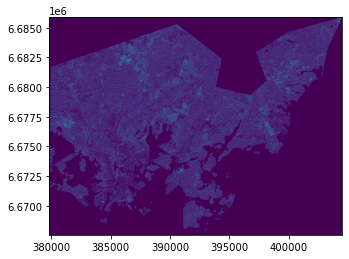

<AxesSubplot:>

In [179]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
%matplotlib inline

# Plot band 4
show((raster, 4), )

Here we can see that the `show` function created a map showing the pixel values of band 1.

## RGB True color composite

For a general overview it often makes sense to also look at the true color image.

- First we need to read the bands into numpy arrays and normalize the cell values into scale ranging from 0.0 to 1.0:

In [268]:
# Read the grid values into numpy arrays
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

print(red.max())
print(green.max())


# Show this first without any of below!
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()

    return ((array - array_min)/(array_max - array_min))

def stretch(array):
    
    min_percent = 2   # Low percentile
    max_percent = 98  # High percentile
    lo, hi = np.percentile(array, (min_percent, max_percent))

    # Apply linear "stretch" - lo goes to 0, and hi goes to 1
    res_img = (array.astype(float) - lo) / (hi-lo)

    #Multiply by 255, clamp range to [0, 255] and convert to uint8
    res_img = np.maximum(np.minimum(res_img*255, 255), 0).astype(np.uint8)

    return res_img

# Normalize the bands
#redn = normalize(red)
#greenn = normalize(green)
#bluen = normalize(blue)

#Stretch
redn = stretch(red)
greenn = stretch(green)
bluen = stretch(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

16208
16880
Normalized bands
0 - 255 mean: 47.805121486274466
0 - 255 mean: 59.28635867005245
0 - 255 mean: 49.8746735072975


As the statistics show, now the arrays have been normalized into scale from 0 to 1. 

- Next we need to stack the values from different values together to produce the RGB true color composite. Since we loaded our data into a numpy array, we can use Numpy's [dstack()](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.dstack.html) -function for this:

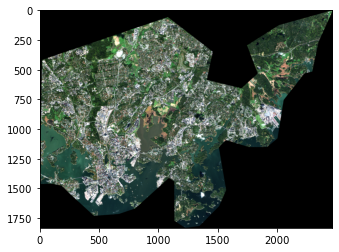

In [269]:
# Create RGB natural color composite stack
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

Here we go, now we have a typical RGB natural color composite image that looks like a photograph taken with the satellite. 

<div class="alert alert-block alert-warning">
    <b>Test your understanding</b> <br>
    ## False color composite
    Following the previous example, it is easy to create false color composites with different band configurations. 
    One of the typical one, is to replace the blue band with near infra-red that can be used to detect vegetation easily where red color is emphasized. Let's use the same raster file as input, and generate our first false color composite:
</div>

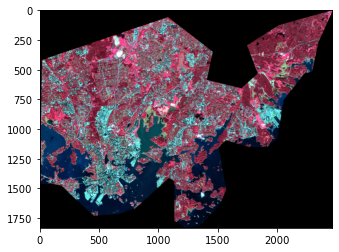

In [270]:
# %load solution_falsecolorcomposite.txt
# Read the grid values into numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Normalize the values using the function that we defined earlier
#nirn = normalize(nir)
#redn = normalize(red)
#greenn = normalize(green)
nirn = stretch(nir)
redn = stretch(red)
greenn = stretch(green)

# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

# Let's see how our color composite looks like
plt.imshow(nrg)

As we can see, now the vegetation can be seen more easily from the image (red color).

## Histogram of the raster data

Typically when working with raster data, you want to look at the histogram of different bands in your data. Luckily that is really easy to do with rasterio by using the `plot.show_hist()` function.


(0.0, 5000.0)

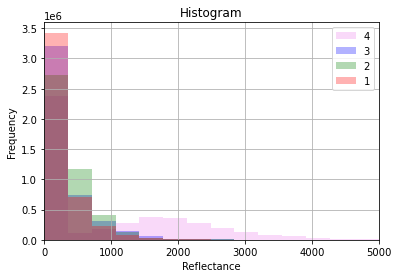

In [199]:
from rasterio.plot import show_hist

fig, axhist = plt.subplots(1, 1)
show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', label = range(1,5), ax = axhist)
axhist.set_xlabel('Reflectance')
#axhist.set_ylabel('Frequency')
axhist.set_title('Histogram')
axhist.set_xlim(left= 0, right= 5000)

Now we can easily see how the wavelengths of different bands are distributed.

# Masking / clipping raster

One common task in raster processing is to clip raster files based on a Polygon. The following example shows how to clip a large raster based on a bounding box around Helsinki Region.


- Import modules and specify the input and output filepaths

In [200]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
#import pycrs
import os
%matplotlib inline

# Output raster
out_tif = os.path.join(data_dir, "S2B_RGBNIR_20210926_Suomenlinna.tif")

- Let's start by opening the raster in read mode and visualizing it (using specific colormap called `terrain`):

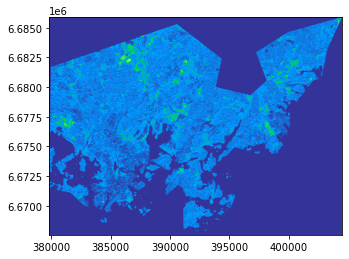

<AxesSubplot:>

In [201]:


# Visualize the NIR band
show((raster, 4), cmap='terrain')

We are looking at Helsinki area. Maybe we are only interested in what is happening in the central park? Let's clip it out from the file.

- First, we need to create a bounding box for our area of interest with Shapely.

In [202]:
# WGS84 coordinates
#Helsinki
#minx, miny = 24.60, 60.00
#maxx, maxy = 25.22, 60.35
#Central park
minx, miny = 24.90, 60.19
maxx, maxy = 24.94, 60.22
#Suomenlinna
#minx, miny = 24.9, 60.13
#maxx, maxy = 25.1, 60.15
bbox = box(minx, miny, maxx, maxy)

<div class="alert alert-block alert-warning">
    <b>Test your understanding</b> <br>
    You can also remember what we did on day one and load the file xx into a geodataframe and check if the CRS is correct (same as raster)
</div>

In [ ]:
%load solution_loadtogdf.txt

- Create a GeoDataFrame from the bounding box

In [203]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
print(geo)

                                            geometry
0  POLYGON ((24.94000 60.19000, 24.94000 60.22000...


/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


As we can see now we have a GeoDataFrame with Polygon inside. To be able to clip the raster with this Polygon, it is required that the data has identical coordinate reference system.

-  Re-project into the same coordinate system as the raster data. We can access the crs of the raster using attribute `.crs`:

In [207]:
# Project the Polygon into same CRS as the grid 
geo = geo.to_crs(crs=raster.crs)

# Print crs
geo.crs


<Derived Projected CRS: EPSG:32635>
Name: WGS 84 / UTM zone 35N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

- Next we need to get the coordinates of the geometry in such a format that rasterio wants them. This can be conducted easily with following function:

In [208]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

- Get the geometry coordinates by using the function.

In [209]:
coords = getFeatures(geo)
print(coords)

#coords = [{'type': 'Polygon', 'coordinates': [[[698592.0, 6697870.5], [698592.0, 6656859.0], [735300.0, 6656859.0], [735300.0, 6697870.5],[698592.0, 6697870.5]]]}]

[{'type': 'Polygon', 'coordinates': [[[385769.90891843603, 6674353.431189198], [385874.16661853256, 6677693.474332802], [383658.6289460426, 6677763.31366388], [383552.34638980555, 6674423.313394659], [385769.90891843603, 6674353.431189198]]]}]


Okay, as we can see rasterio wants to have the coordinates of the Polygon in `GeoJSON` format.

- Now we are ready to clip the raster with the polygon using the `coords` variable that we just created. Clipping the raster can be done easily with the `mask` function that we imported in the beginning from `rasterio`, and specifying ``clip=True``.


In [210]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=raster, shapes=coords, crop=True)

- Next, we need to modify the metadata. Let's start by copying the metadata from the original data file.

In [211]:
# Copy the metadata
out_meta = raster.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2466, 'height': 1832, 'count': 4, 'crs': CRS.from_epsg(32635), 'transform': Affine(10.0, 0.0, 379820.0,
       0.0, -10.0, 6685870.0)}


- Next we need to parse the EPSG value from the CRS so that we can create a `Proj4` -string using `PyCRS` library (to ensure that the projection information is saved correctly).

In [214]:
# Parse EPSG code
epsg_code = raster.crs.data['init']
print(epsg_code)


epsg:32635


- Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text):

In [215]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": epsg_code})

- Finally, we can save the clipped raster to disk with following command:

In [216]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

- Let's still check that the result is correct by plotting our new clipped raster.

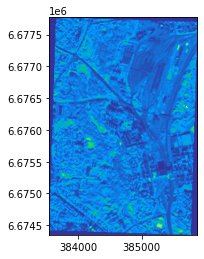

<AxesSubplot:>

In [218]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

# Visualize
show((clipped, 4), cmap='terrain')

Great, it worked! This is how you can easily clip (*mask*) raster files with rasterio.

# Raster map algebra

Conducting calculations between bands or raster is another common GIS task. Here, we will be calculating `NDVI` (Normalized difference vegetation index) based on the Sentinel-2 dataset that we just clipped. Conducting calculations with rasterio is fairly straightforward if the extent etc. matches because the values of the rasters are stored as `numpy` arrays.

## Calculating NDVI 

In this tutorial, we will see how to calculate the NDVI (Normalized difference vegetation index) based on two bands: band-4 (in our case 3) which is the Red channel and band-8 (in our case 4) which is the Near Infrared (NIR).

- Let's read the red and NIR bands from our raster source ([ref](https://etsin.avointiede.fi/storage/f/paituli/latuviitta/Landsat_kanavat.pdf)):

633.9234871872098
1565.4194965238562
<class 'numpy.ndarray'>


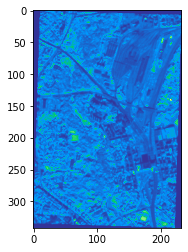

<AxesSubplot:>

In [221]:
# Read red channel (our channel number 3)
red = clipped.read(3)
# Read NIR channel (our channel number 4)
nir = clipped.read(4)

# Calculate some stats to check the data
print(red.mean())
print(nir.mean())
print(type(nir))

# Visualize
show(nir, cmap='terrain')

As we can see the values are stored as `numpy.ndarray`. From the map we can see that NIR channel reflects stronly (light green) in areas outside the Helsinki urban areas.

- Let's change the data type from uint16 to float so that we can have floating point numbers stored in our arrays:

In [223]:
# Convert to floats
red = red.astype('f4')
nir = nir.astype('f4')

Now we can see that the numbers changed to decimal numbers (there is a dot after the zero).

Next we need to tweak the behaviour of numpy a little bit. By default numpy will complain about dividing with zero values. We need to change that behaviour because we have a lot of 0 values in our data.


In [224]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

- Now we are ready to calculate the NDVI. This can be done easily with simple map algebra and using the NDVI formula and passing our numpy arrays into it:

In [225]:
# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)

- Let's plot the results so we can see how the index worked out:

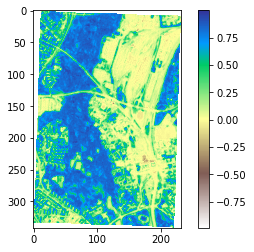

In [226]:
%matplotlib inline
# Plot the NDVI
plt.imshow(ndvi, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar()

As we can see from the map, really low NDVI values are located in water and urban areas (ie Pasila train network) whereas the areas colored in blue indicate a lot of vegetation according our NDVI index (central park). 

<div class="alert alert-block alert-warning">
    <b>Test your understanding</b> <br>
    Choose another index to calculate and plot the result.<br>
</div>
    * SAVI challenge<br>
    * Colormap


In [ ]:
%load untitled.txt

# Creating a raster mosaic

Quite often you need to merge multiple raster files together and create a `raster mosaic`. This can be done easily with the `merge()` -function in Rasterio.

Here, we will create a mosaic based on 2X2m resolution DEM files (altogether 6 files) covering part of Helsinki region. If you have not downloaded the DEM files yet, you can do that by running the script from download-data -section of the tutorial.

As there are many `tif` files in our folder, it is not really pracical to start listing them manually. Luckily, we have a module and function called `glob` that can be used to create a list of those files that we are interested in based on search criteria.

Let's start by:
   
  - Importing required modules
  - Finding all `tif` files from the folder where the file starts with `L` -letter.


In [229]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
%matplotlib inline

# File and folder paths
dirpath = "./data/mml/dem2m/2008_latest/L4/L41"
out_fp = os.path.join(dirpath, "Helsinki_DEM2x2m_Mosaic.tif")

# Make a search criteria to select the DEM files
search_criteria = "L*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

./data/mml/dem2m/2008_latest/L4/L41/L*.tif


Now we can see that we have a search criteria (variable `q`) that we can pass to `glob` -function.

- List all digital elevation files with glob() -function:

In [230]:
# glob function can be used to list files from a directory with specific criteria
dem_fps = glob.glob(q)

# Files that were found:
dem_fps

['./data/mml/dem2m/2008_latest/L4/L41/L4133A.tif',
 './data/mml/dem2m/2008_latest/L4/L41/L4133B.tif',
 './data/mml/dem2m/2008_latest/L4/L41/L4133C.tif',
 './data/mml/dem2m/2008_latest/L4/L41/L4133D.tif',
 './data/mml/dem2m/2008_latest/L4/L41/L4134A.tif',
 './data/mml/dem2m/2008_latest/L4/L41/L4134C.tif']

Great! Now we have all those 6 files in a list and we can start to make a mosaic out of them.

- Let's first create a list for the source raster datafiles (in read mode) with rasterio that will be used to create the mosaic:


In [231]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic


[<open DatasetReader name='./data/mml/dem2m/2008_latest/L4/L41/L4133A.tif' mode='r'>,
 <open DatasetReader name='./data/mml/dem2m/2008_latest/L4/L41/L4133B.tif' mode='r'>,
 <open DatasetReader name='./data/mml/dem2m/2008_latest/L4/L41/L4133C.tif' mode='r'>,
 <open DatasetReader name='./data/mml/dem2m/2008_latest/L4/L41/L4133D.tif' mode='r'>,
 <open DatasetReader name='./data/mml/dem2m/2008_latest/L4/L41/L4134A.tif' mode='r'>,
 <open DatasetReader name='./data/mml/dem2m/2008_latest/L4/L41/L4134C.tif' mode='r'>]

As we can see, now the list contains all those files as raster objects in read mode (´mode='r'´).

- Let's plot a few of them next to each other to see how they look like:

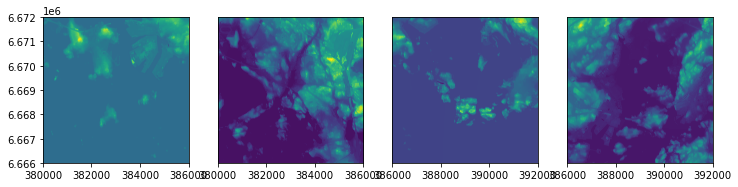

In [232]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(src_files_to_mosaic[0], ax=ax1)
show(src_files_to_mosaic[1], ax=ax2)
show(src_files_to_mosaic[2], ax=ax3)
show(src_files_to_mosaic[3], ax=ax4)

# Do not show y-ticks values in last three axis
for ax in [ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)
    

As we can see we have multiple separate raster files that are actually located next to each other. Hence, we want to put them together into a single raster file that can by done by creating a raster mosaic.

- Now as we have placed the individual raster files in read -mode into the `source_files_to_mosaic` -list, it is really easy to merge those together and create a mosaic with rasterio's `merge` function:

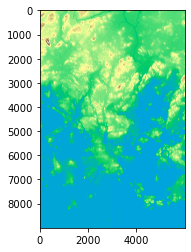

<AxesSubplot:>

In [233]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# Plot the result
show(mosaic, cmap='terrain')

Great, it looks correct! Now we are ready to save our mosaic to disk.

- Let's first update the metadata with our new dimensions, transform and CRS:

In [234]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                 }
                )

- Finally we can write our mosaic to our computer:

In [236]:
# Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

That's it! Easy!

Check out also other tools, eg for mosaicing Sentinel-2 data: [sen2mosaic](https://sen2mosaic.readthedocs.io/en/latest/), not currently installed to notebooks. 

However following these ways, the filesize can get really big, to avoid that, take a look at virtual rasters as well: https://docs.csc.fi/support/tutorials/gis/virtual-rasters/ .

Zonal statistics
================

Quite often you have a situtation when you want to summarize raster datasets based on vector geometries, such as calculating the average elevation of specific area.

[Rasterstats](https://github.com/perrygeo/python-rasterstats) is a Python module that does exactly that.

- Let's use our newly created mosaic:

In [237]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import osmnx as ox
import geopandas as gpd
import os
import matplotlib.pyplot as plt
%matplotlib inline


# Read the just created Digital Elevation Model for Helsinki
dem = rasterio.open(out_fp)
dem

<open DatasetReader name='./data/mml/dem2m/2008_latest/L4/L41/Helsinki_DEM2x2m_Mosaic.tif' mode='r'>

Good, now our elevation data is in read mode.

Next, we want to calculate the elevation of two neighborhoods located in Helsinki, called `Kallio` and `Pihlajamäki`, and find out which one of them is higher based on the elevation data. We will use a package called [OSMnx](https://github.com/gboeing/osmnx) to fetch the data from OpenStreetMap for those areas.

- Specify place names for `Kallio` and `Pihlajamäki` that Nominatim can identify https://nominatim.openstreetmap.org/, and retrieve the 

In [239]:
# Keywords for Kallio and Helsinki in such format that they can be found from OSM
kallio_q = "Kallio, Helsinki, Finland"
pihlajamaki_q = "Pihlajamäki, Malmi, Helsinki, Finland"

# Retrieve the geometries of those areas using osmnx
kallio = ox.geocode_to_gdf(kallio_q)
pihlajamaki = ox.geocode_to_gdf(pihlajamaki_q)

# Reproject to same coordinate system as the 
kallio = kallio.to_crs(crs=dem.crs)
pihlajamaki = pihlajamaki.to_crs(crs=dem.crs)

type(kallio)

/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


geopandas.geodataframe.GeoDataFrame

As we can see, now we have retrieved data from OSMnx and they are stored as GeoDataFrames.

- Let's see how our datasets look by plotting the DEM and the regions on top of it

<AxesSubplot:>

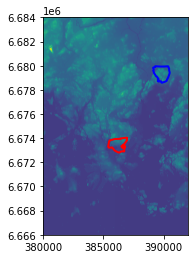

In [240]:
# Plot the Polygons on top of the DEM
ax = kallio.plot(facecolor='None', edgecolor='red', linewidth=2)
ax = pihlajamaki.plot(ax=ax, facecolor='None', edgecolor='blue', linewidth=2)

# Plot DEM
show((dem, 1), ax=ax)

**Which one is higher? Kallio or Pihlajamäki? We can use zonal statistics to find out!**

- First we need to get the values of the dem as numpy array and the affine of the raster

In [241]:
# Read the raster values
array = dem.read(1)

# Get the affine
affine = dem.transform

- Now we can calculate the zonal statistics by using the function `zonal_stats`.

In [242]:
# Calculate zonal statistics for Kallio
zs_kallio = zonal_stats(kallio, array, affine=affine, stats=['min', 'max', 'mean', 'median', 'majority'])

# Calculate zonal statistics for Pihlajamäki
zs_pihla = zonal_stats(pihlajamaki, array, affine=affine, stats=['min', 'max', 'mean', 'median', 'majority'])


/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Okey. So what do we have now?

In [243]:
print(zs_kallio)
print(zs_pihla)

[{'min': -2.1760001182556152, 'max': 37.388999938964844, 'mean': 12.714295629156176, 'median': 11.09000015258789, 'majority': -0.014000000432133675}]
[{'min': 8.621999740600586, 'max': 46.30400085449219, 'mean': 24.559830083614287, 'median': 24.177000045776367, 'majority': 10.41100025177002}]


Super! Now we can see that Pihlajamäki seems to be slightly higher compared to Kallio.

# Read data from Allas



In [272]:
r = rasterio.open('/vsicurl/https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki_Allas.tif')
input_data = r.read()


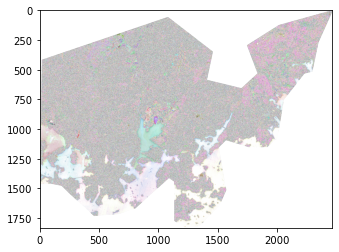

<AxesSubplot:>

In [271]:
input_data

show(input_data,1)

# Read Cloud Optimized Geotiffs

The following materials are based on [this tutorial](https://geohackweek.github.io/raster/04-workingwithrasters/). Read more from that tutorial until this one get's better updated.

- Let's read a Landsat TIF profile from AWS cloud storage:

In [244]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Specify the path for Landsat TIF on AWS
fp = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

# See the profile
with rasterio.open(fp) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


- Let's plot a low resolution overview:

Decimation factor= 81
array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0, 0.5, 'Row #')

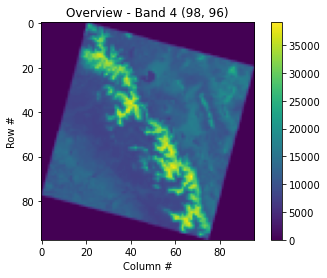

In [245]:
%matplotlib inline
# Open the COG
with rasterio.open(fp) as src:
    # List of overviews from biggest to smallest
    oviews = src.overviews(1) 
    
    # Retrieve the smallest thumbnail
    oview = oviews[-1] 
    print('Decimation factor= {}'.format(oview))
    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

- Let's fix the NoData values to be `NaN` instead of 0:

Decimation factor= 81


Text(0, 0.5, 'Row #')

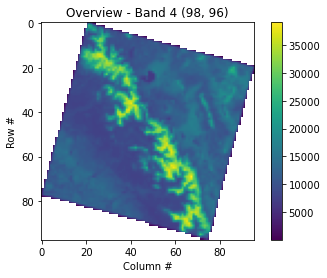

In [246]:
# Open the file
with rasterio.open(fp) as src:
    # Access the overviews
    oviews = src.overviews(1)
    oview = oviews[-1]
    
    print('Decimation factor= {}'.format(oview))
    
    # Read the thumbnail
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
    # Convert the values into float
    thumbnail = thumbnail.astype('f4')
    
    # Convert 0 values to NaNs
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

- Let's take a subset from high resolution image:

Text(0, 0.5, 'Row #')

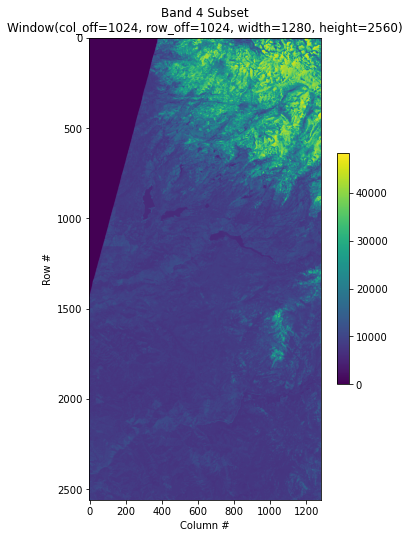

In [247]:
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

with rasterio.open(fp) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

These commands demonstrate the basics how to use COGs to retrieve data from the cloud.